In [2]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA

In [3]:
# load the data
data = sio.loadmat('Data/illumination.mat')

In [4]:
# get all the poses for different subjects
illum = data.get('illum')
illum.shape

(1920, 21, 68)

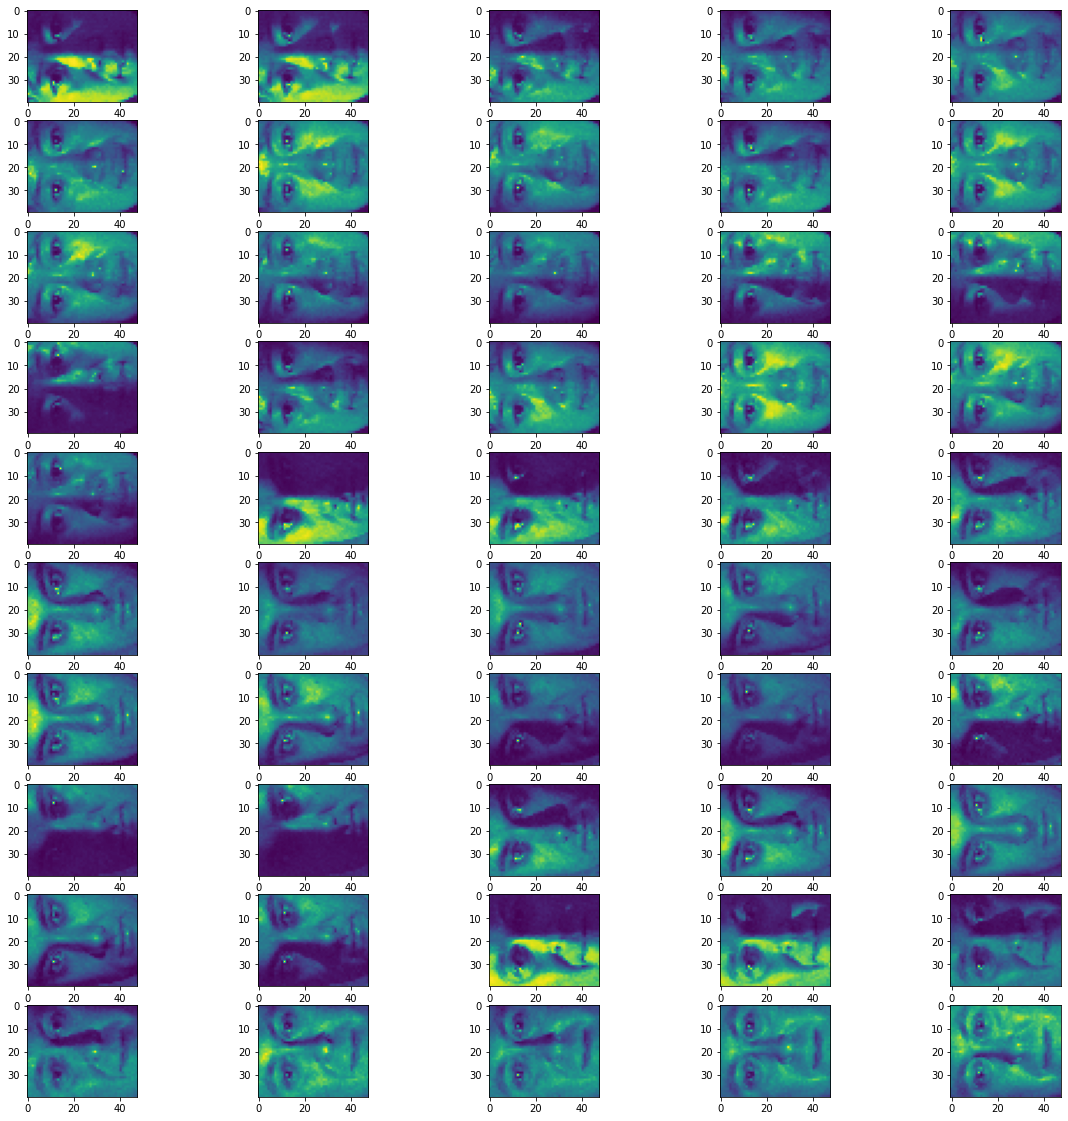

In [5]:
fig, ax_array = plt.subplots(nrows=10, ncols=5, figsize=(20,20))

# flatten the array of axes, which makes them easier to iterate through and assign
ax_array = ax_array.flatten()
c = 0
d = 0
# plot some poses
for i, ax in enumerate(ax_array):
    if c == 21:
        c = 0
        d += 1
    ax.imshow(illum[:,c,d].reshape(40,48))
    c+=1

# Build up the training and testing data

## Flatten the data set

In [6]:
subjects = 68
types = 21
flattened = np.zeros(shape=(subjects*types, illum.shape[0]))
c = 0
d = 0
for i in range(flattened.shape[0]):
    if c == types:
        c = 0
        d += 1
    flattened[i] = illum[:,c,d]
    c += 1


## Check for PCA 95% retention

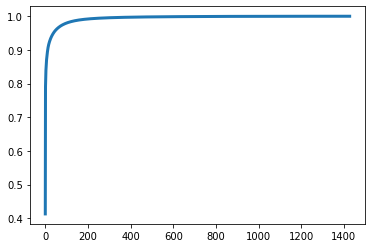

In [7]:
pca = PCA().fit(flattened)
plt.figure()
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [8]:
np.where(pca.explained_variance_ratio_.cumsum() > 0.95)

(array([  39,   40,   41, ..., 1425, 1426, 1427], dtype=int64),)

In [9]:
# above figure shows 95% retention at dimension >= 200
# we will apply PCA to reduce dimension to 200
usePCA = True
pca = PCA(50)
projected = pca.fit_transform(flattened)
print(projected.shape)

(1428, 50)


In [10]:
import random
def get_training_and_testing_data(data, subjects, types, pca):
    if pca:
        size = data.shape[1]
    else:
        size = data.shape[0]*data.shape[1]
    training_data = []
    testing_data = []
    training_size = math.ceil(types*(2/3))
    testing_size = types - training_size
    subject = 0
    for i in range(subjects):
        temp = dict()
        temp['data'] = []

        for j in range(types):
            if pca:
                temp['data'].append((data[subject]))
                subject += 1
            else:
                temp['data'].append((data[:,:,j,i]).flatten())

        # random.shuffle(temp['data']) # shuffle the data
        tr = temp['data'][:training_size] # training batch
        te = temp['data'][training_size:] # testing batch
        # te = temp['data'][:testing_size]
        # tr = temp['data'][testing_size:]
        training_data.append({'class': i, 'data':tr})
        testing_data.append({'class': i, 'data': te})
    
    return training_data, testing_data, training_size, testing_size
            

In [11]:
training_data, testing_data, training_size, testing_size = get_training_and_testing_data(projected, subjects=68, types=21, pca=True)

In [12]:
print(training_data[0]['data'][8].shape)
print(training_data[0]['data'][0].shape)
print(training_size, testing_size)
print(len(training_data))
print(len(testing_data))

(50,)
(50,)
14 7
68
68


# Compute the Covariance and Mean of each class

In [13]:
mu = []
cov = []
for i in range(len(training_data)):
    matrix = np.array(training_data[i]['data'])
    mean = np.sum(matrix, axis=0)/matrix.shape[0]
    cov_ = (np.matmul((matrix - mean).T, (matrix-mean))) / matrix.shape[0]
    noise = 0.01*np.identity(cov_.shape[0])
    cov_ = cov_ + noise
    cov.append(cov_)
    mu.append(mean)
    if np.linalg.det(cov_) == 0 or np.linalg.det(cov_) == 0.0:
        print('alert - zero determinant')

In [14]:
usePCA = True

# Find the maximum likelihood for each subject

In [15]:
score = 0
total_test_samples = len(testing_data)*testing_size
for i in range(subjects):
    for j in range(testing_size):
        test_data = testing_data[i]['data']
        likelihood_list = []
        for k in range(subjects):
            likelihood = (-0.5)*math.log(np.linalg.det(cov[k])) - (0.5)*np.dot( test_data[j]-mu[k], np.dot( np.linalg.inv(cov[k]), (test_data[j]-mu[k]).T ) )
            likelihood_list.append(likelihood)
        temp = np.array(likelihood_list)
        if np.argmax(temp) == i:
            score += 1
            print('Correct, score is now ', score)
        else:
            print('Incorrect Score for subject ', i)
print('Accuracy = ', (score*100/total_test_samples))

Correct, score is now  1
Correct, score is now  2
Correct, score is now  3
Correct, score is now  4
Correct, score is now  5
Correct, score is now  6
Correct, score is now  7
Correct, score is now  8
Correct, score is now  9
Correct, score is now  10
Correct, score is now  11
Correct, score is now  12
Correct, score is now  13
Correct, score is now  14
Correct, score is now  15
Correct, score is now  16
Correct, score is now  17
Correct, score is now  18
Correct, score is now  19
Correct, score is now  20
Correct, score is now  21
Correct, score is now  22
Correct, score is now  23
Correct, score is now  24
Correct, score is now  25
Correct, score is now  26
Correct, score is now  27
Correct, score is now  28
Correct, score is now  29
Correct, score is now  30
Correct, score is now  31
Correct, score is now  32
Correct, score is now  33
Correct, score is now  34
Correct, score is now  35
Correct, score is now  36
Correct, score is now  37
Correct, score is now  38
Correct, score is now

In [16]:
print('Accuracy = ', (score*100/total_test_samples))

Accuracy =  99.78991596638656
